In [1]:
import os
import pickle

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from model import FiringRateModel, PolynomialActivation, train_model
from data import load_data, preprocess_data, get_train_test_data

In [2]:
#device = torch.device("mps")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def data_lens(Is):
    lens = [len(a) for a in Is]
    counts = {}
    for l in lens:
        if l not in counts:
            counts[l] = 0
        counts[l] += 1
    print(counts)

def predict(model, Is, fs):
    k, l = model.k, model.l
    with torch.no_grad():
        fs2 = fs[:max(k, l)]
        pred_fs = []
        for i in range(max(k, l), len(Is)):
            currs = Is[i-k:i+1]
            f = model(currs, fs2[i-l:i])
            fs2 = torch.cat((fs2, f.reshape(1)))
            pred_fs.append(f)
    return pred_fs

def plot_predictions(model, Is, fs):
    pred_fs = predict(model, Is, fs)
    ts = list(range(max(k, l+1), len(fs)))
    plt.plot(ts, fs[max(k, l+1):], label="Actual")
    plt.plot(ts, pred_fs, label="Predicted")
    plt.legend()
    plt.ylabel("Firing rate")
    plt.xlabel("t")

In [4]:
data = load_data(with_zero=True)
data.keys()

dict_keys([583836069, 565871768, 605889373])

In [35]:
bin_size = 50
cell_id = 605889373
k = 2
l = 1
loss_fn = "poisson"
Is_tr, fs_tr, Is_te, fs_te = get_train_test_data(data, cell_id, bin_size, device=device)
data_lens(Is_tr)
data_lens(Is_te)

{25: 17, 145: 25, 185: 2, 105: 12, 545: 3, 180: 1, 149: 10}
{545: 3}


In [36]:
actv = PolynomialActivation()
actv.init_from_file(f"model/activation/{loss_fn}/bin_size_{bin_size}/{cell_id}_1e-05.pickle")

model = FiringRateModel(actv, k=k, l=l).to(device)
if loss_fn == "poisson":
    criterion = torch.nn.PoissonNLLLoss(log_input=False)
elif loss_fn == "huber":
    criterion = torch.nn.HuberLoss()
    #criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

train_model(
    model, 
    criterion, 
    optimizer,
    Is_tr,
    fs_tr,
    epochs = 100,
    print_every = 10,
    loss_fn = loss_fn,
    bin_size = bin_size,
    up_factor = 1
)

Epoch 10 / Loss: 5697.635902404785
Epoch 20 / Loss: 6323.59490776062
Epoch 30 / Loss: 5173.686698436737
Epoch 40 / Loss: 7511.921932220459
Epoch 50 / Loss: 7420.170021057129
Epoch 60 / Loss: 7233.762382507324
Epoch 70 / Loss: 6553.4664478302
Epoch 80 / Loss: 3968.395830154419
Epoch 90 / Loss: 3054.2093753814697
Epoch 100 / Loss: 5336.176949381828


/var/folders/1d/cmypn_251jlfyvc132scjqd40000gp/T/ipykernel_32394/92414586.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


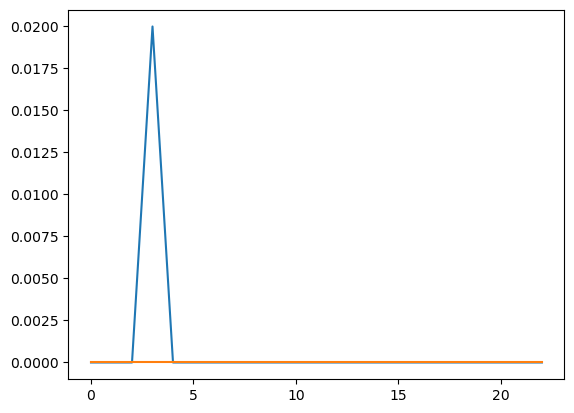

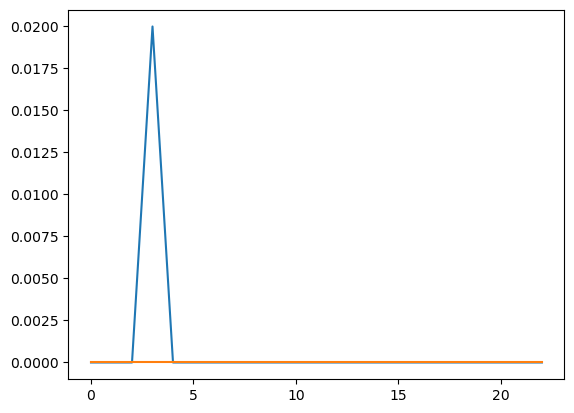

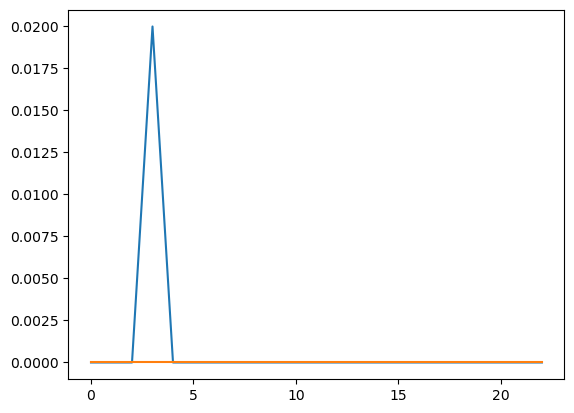

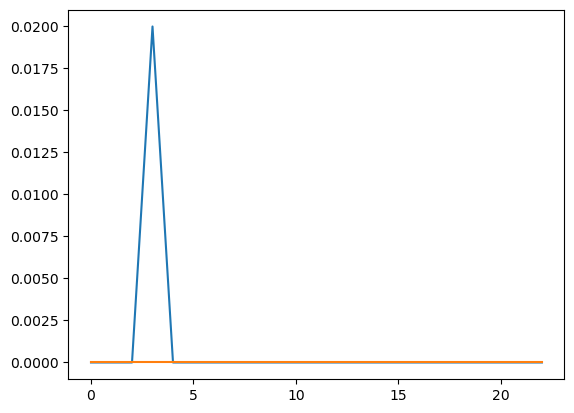

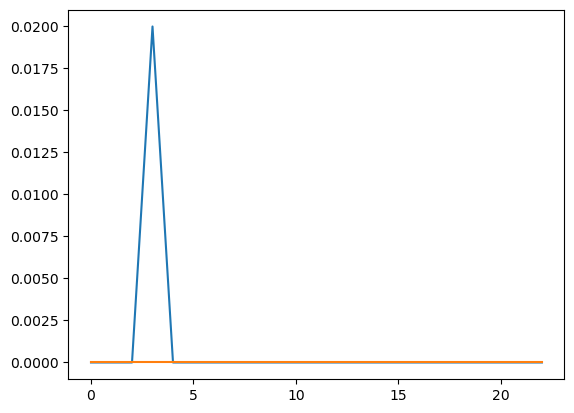

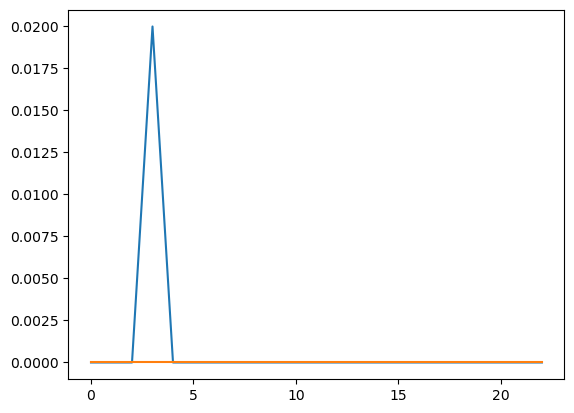

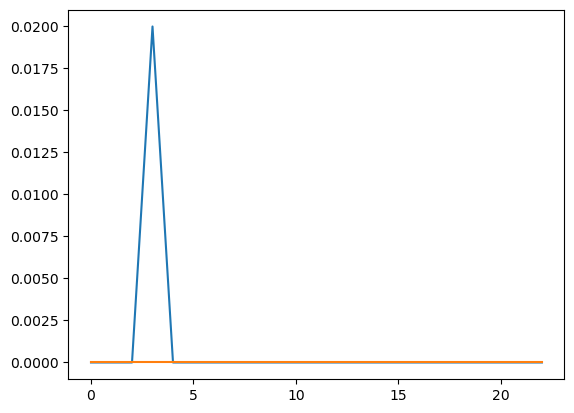

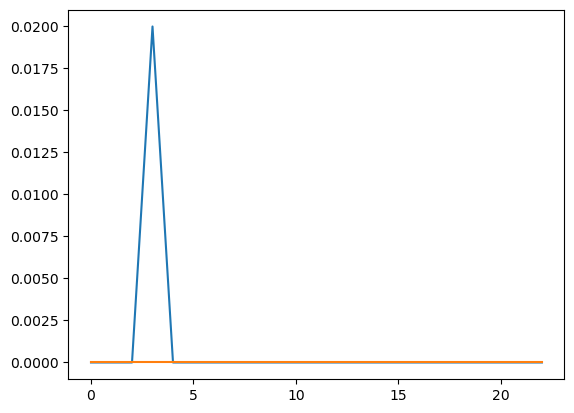

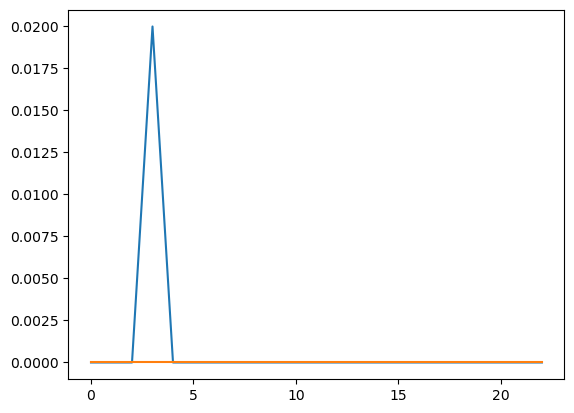

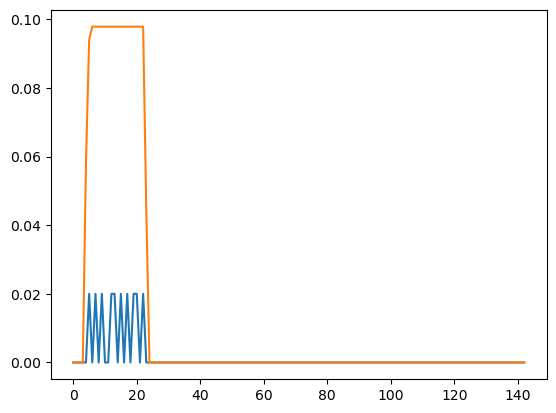

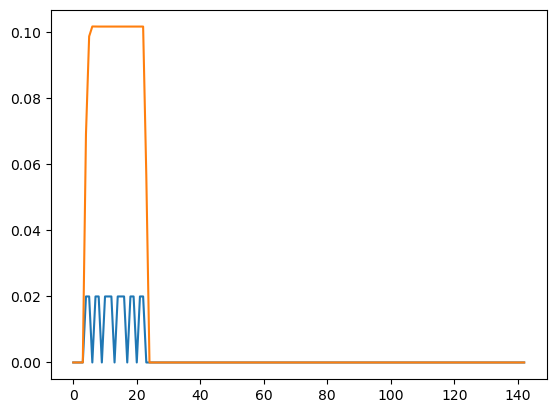

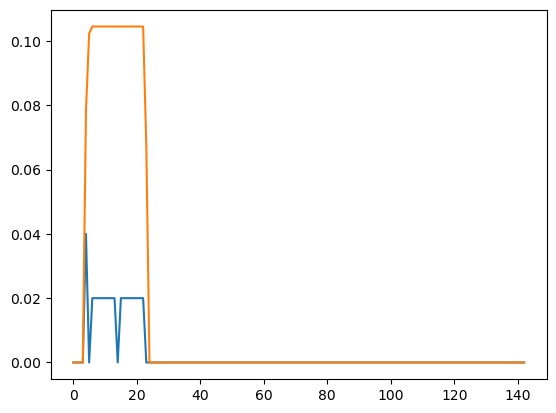

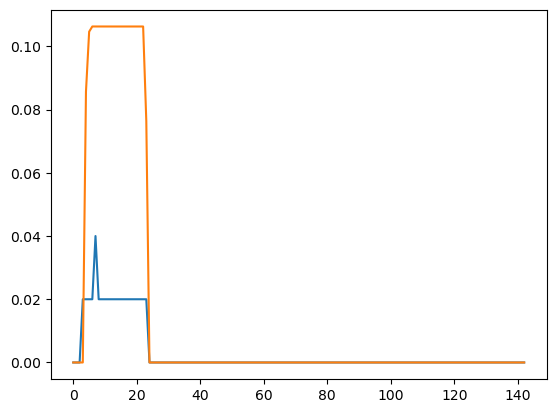

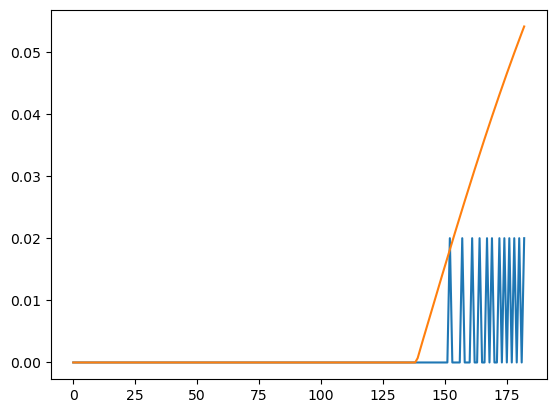

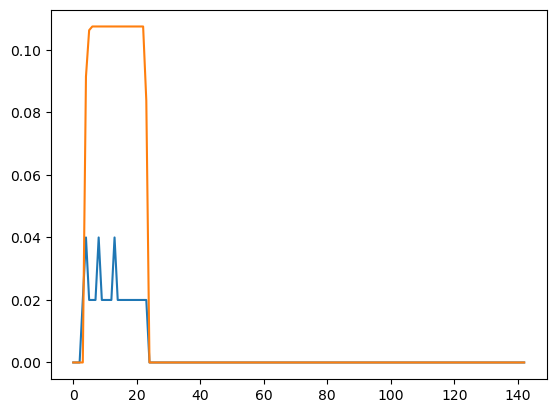

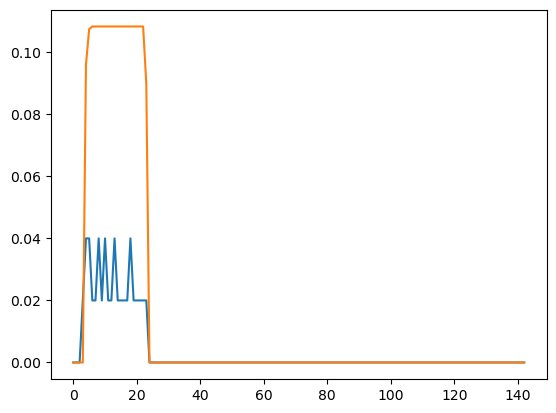

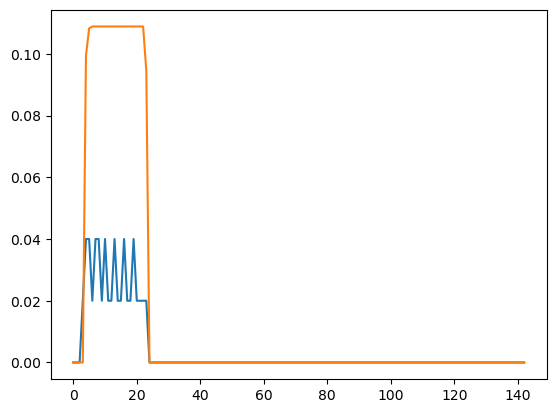

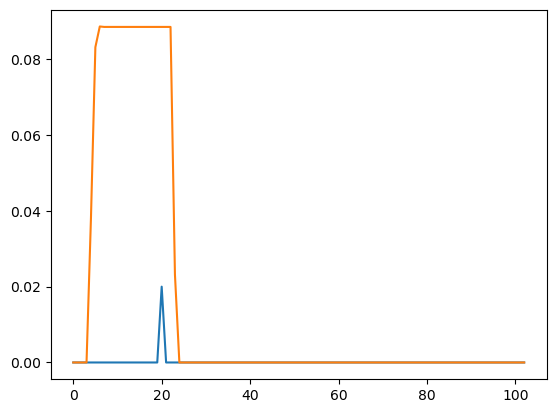

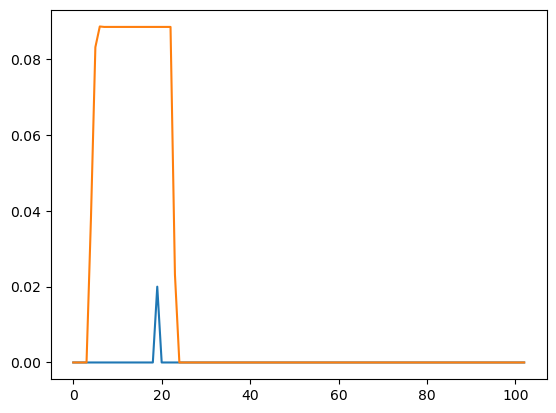

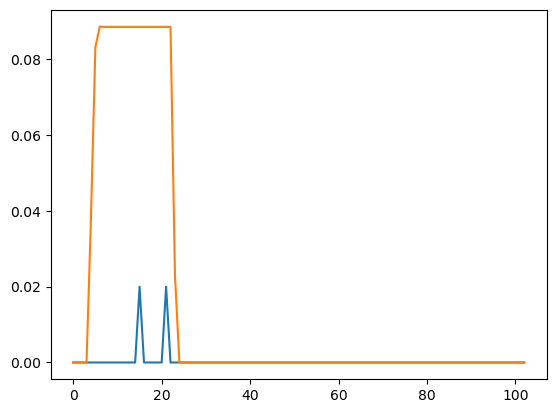

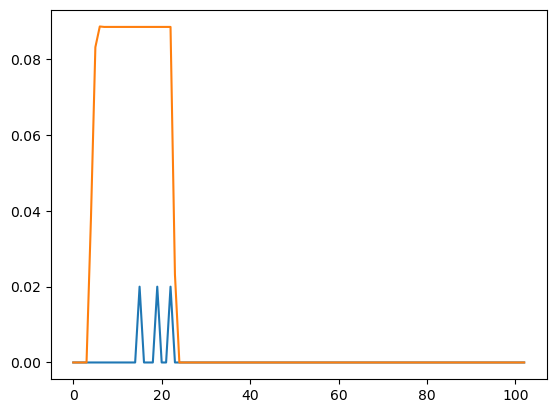

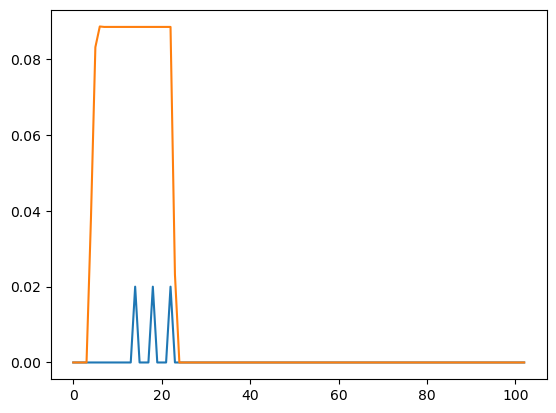

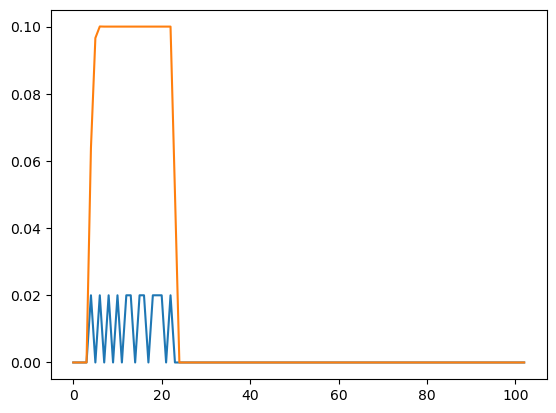

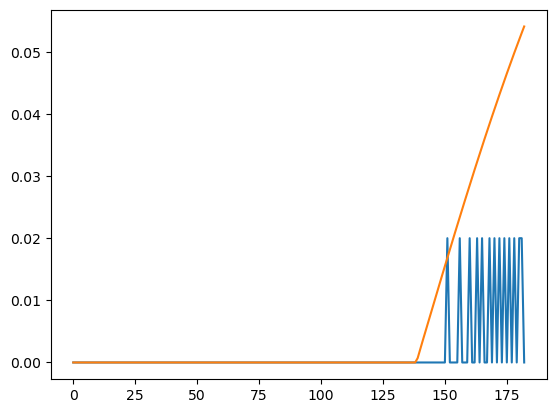

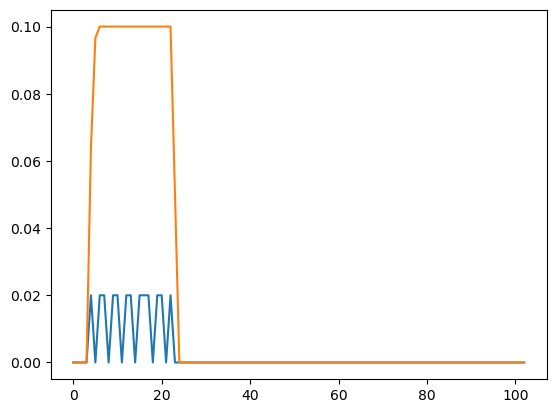

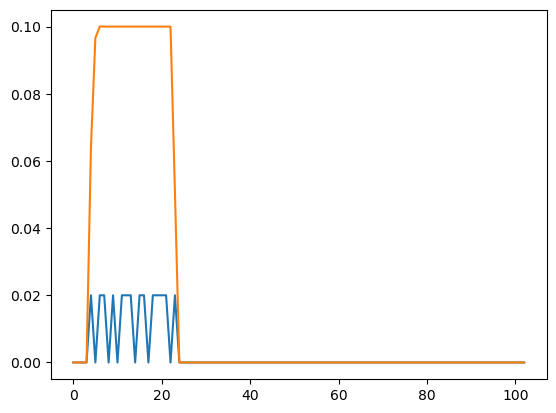

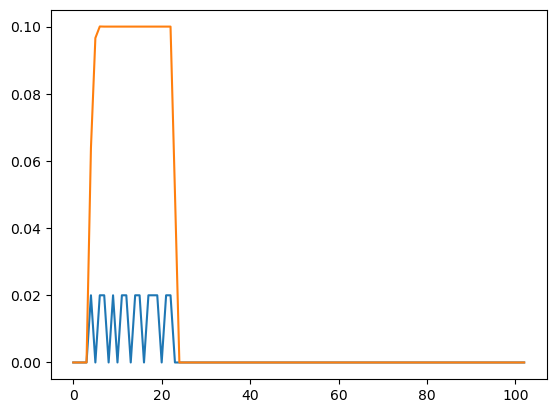

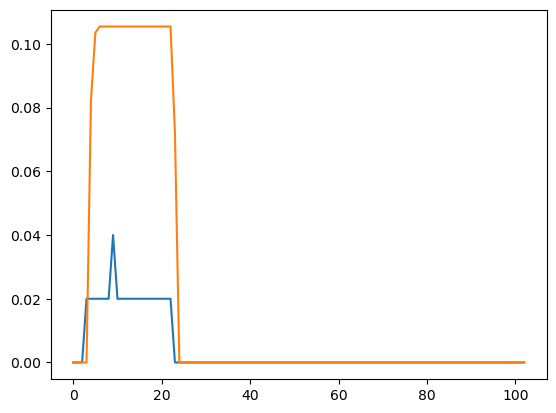

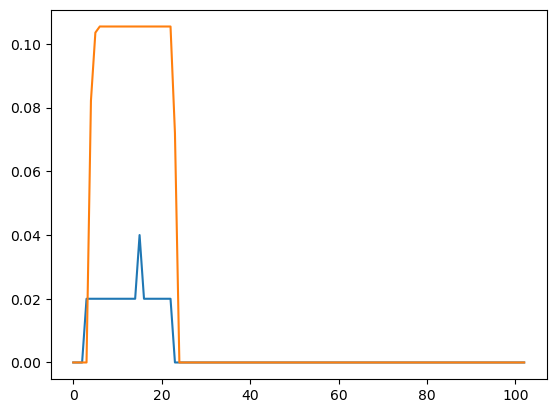

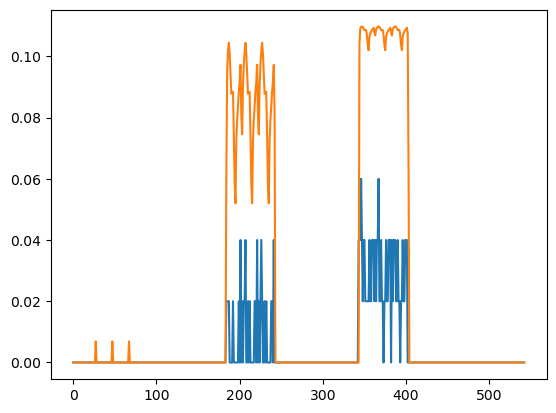

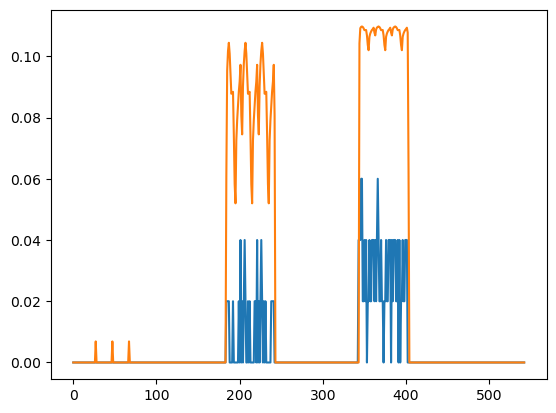

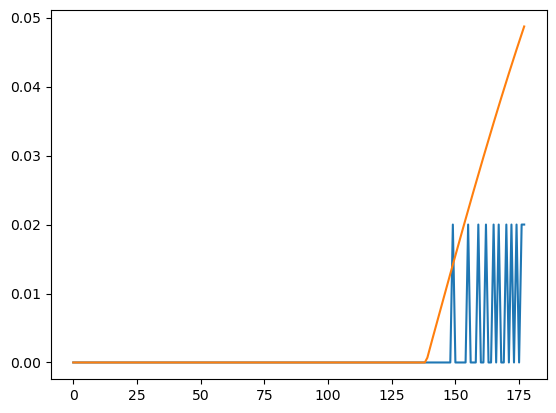

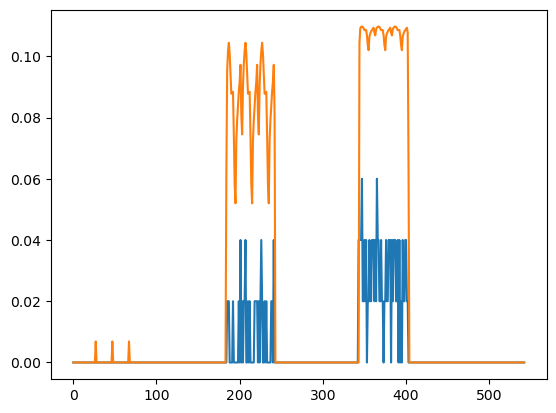

In [37]:
for i in range(len(Is_tr)):
    if not torch.all(fs_tr[i] <= 0.01):
        plt.figure()
        pred_fs = predict(model, Is_tr[i], fs_tr[i])
        ts = list(range(len(Is_tr[i])-max(k, l)))
        plt.plot(ts, fs_tr[i][max(k, l):])
        plt.plot(ts, pred_fs)

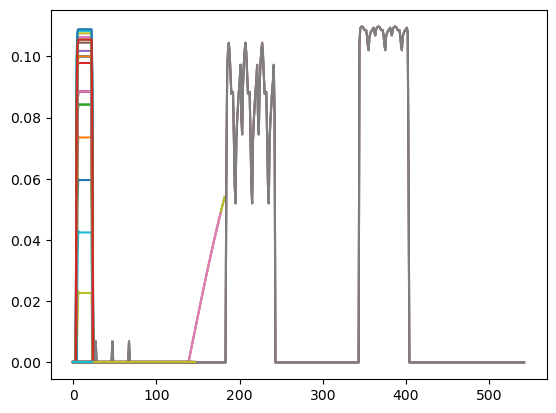

In [38]:
for i in range(len(Is_tr)):
    pred_fs = predict(model, Is_tr[i], fs_tr[i])
    ts = list(range(len(Is_tr[i])-max(k, l)))
    plt.plot(ts, pred_fs)

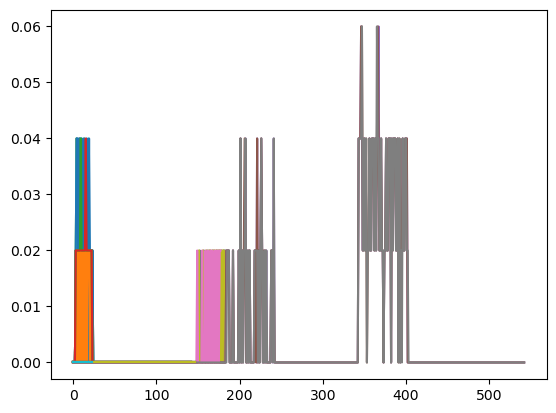

In [39]:
for i in range(len(Is_tr)):
    ts = list(range(len(Is_tr[i])-max(k, l)))
    plt.plot(ts, fs_tr[i][max(k, l):])

In [23]:
print(model.a, model.b)
print(model.g.poly_coeff)

Parameter containing:
tensor([1.2955, 1.6052], requires_grad=True) Parameter containing:
tensor([2.6508, 5.0757], requires_grad=True)
Parameter containing:
tensor([ 3.2343e-01,  1.5173e+00, -1.9401e-12, -2.5474e-11,  3.5144e-12,
        -1.5782e-11])


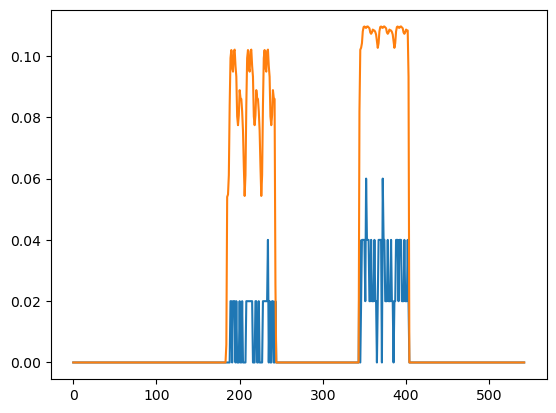

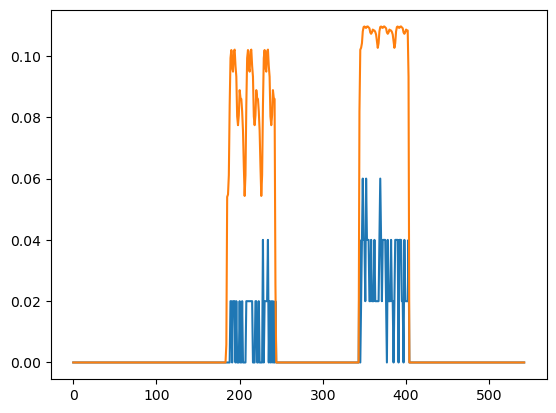

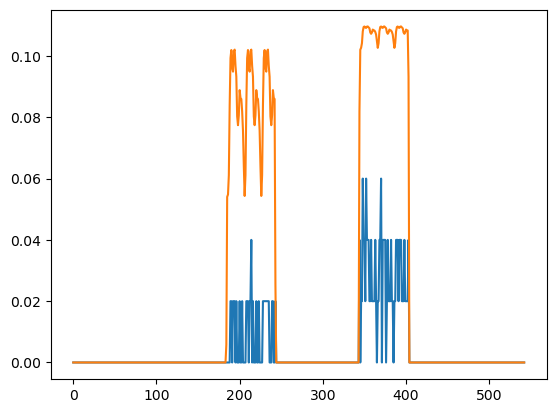

In [40]:
for i in range(len(Is_te)):
    if not torch.all(fs_te[i] <= 0.01):
        plt.figure()
        pred_fs = predict(model, Is_te[i], fs_te[i])
        ts = list(range(len(Is_te[i])-max(k, l)))
        plt.plot(ts, fs_te[i][max(k, l):])
        plt.plot(ts, pred_fs)

In [41]:
def quantize(pred_fs):
    p = torch.tensor(pred_fs).clone()
    return (p * 50 + 0.5).type(torch.int32).type(torch.float32) / 50

In [42]:
from torcheval.metrics import R2Score

R^2: tensor(-12.7858)


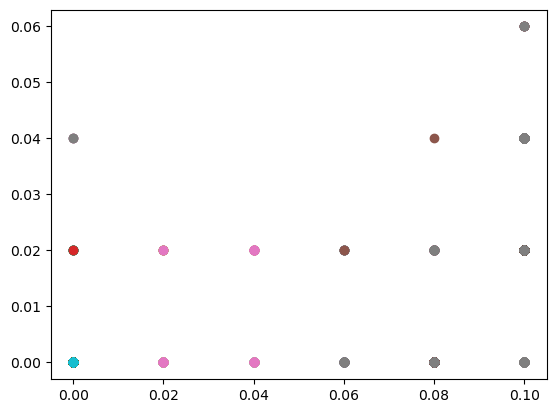

In [43]:
quantized_preds = []
truncated_fs = []
for i in range(len(Is_tr)):
    pred_fs = predict(model, Is_tr[i], fs_tr[i])
    p = quantize(pred_fs)
    quantized_preds.append(p)
    truncated_fs.append(fs_tr[i][max(k, l):])
    plt.scatter(p, fs_tr[i][max(k, l):])

metric = R2Score()
metric.update(torch.cat(quantized_preds), torch.cat(truncated_fs))
print("R^2:", metric.compute())

R^2: tensor(-9.1114)


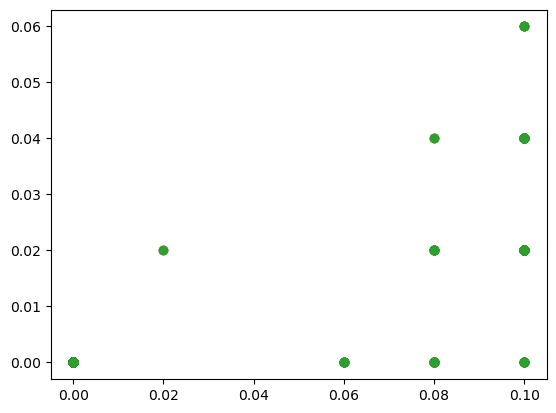

In [44]:
quantized_preds = []
truncated_fs = []
for i in range(len(Is_te)):
    #plt.figure()
    pred_fs = predict(model, Is_te[i], fs_te[i])
    p = quantize(pred_fs)
    quantized_preds.append(p)
    truncated_fs.append(fs_te[i][max(k, l):])
    plt.scatter(p, fs_te[i][max(k, l):])
    
metric = R2Score()
metric.update(torch.cat(quantized_preds), torch.cat(truncated_fs))
print("R^2:", metric.compute())